In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Titanic Survival Prediction Analysis

This notebook aims to predict the survival of passengers on the Titanic using various machine learning techniques.

In this analysis, we will begin by exploring the dataset to understand its structure and the types of features available. We will look into the distribution of key features, such as age, gender, and passenger class, and how they relate to the survival rate. 

Next, we will perform data preprocessing to prepare the data for modeling. This step will include handling missing values, encoding categorical variables, and scaling numerical features. 

We will experiment with different algorithms, including:

1. **CatBoostClassifier**
2. **XGBoostClassifier**
3. **RandomForestClassifier**

We are also going to use model stacking. This means we'll take the predictions from the other models and use them as input for a Support Vector Classifier (SVC). The SVC will be our final model, combining what each of the other models has learned to give us more accurate results.

After training our models, we will evaluate their performance using accuracy metric.



## Import necessary libraries for data manipulation and modeling

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

## Load the Titanic dataset

In [3]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")

## Data Exploration and Visualization

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Visualize the distribution of survivors by sex


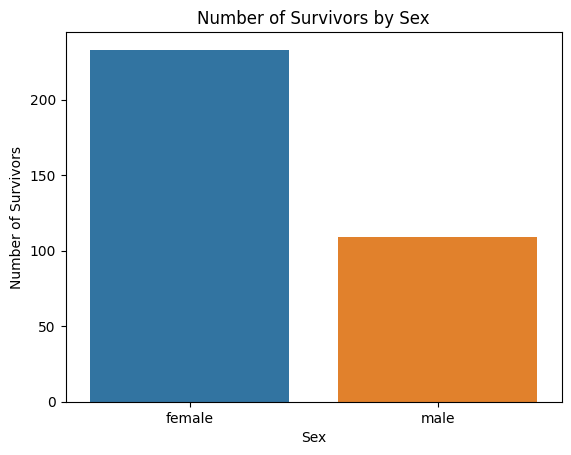

In [6]:
survivedBySex = train_df.groupby("Sex")["Survived"].sum().reset_index()


sns.barplot(x = "Sex", y = "Survived", data = survivedBySex)
plt.xlabel('Sex')
plt.ylabel('Number of Survivors')
plt.title('Number of Survivors by Sex')
plt.show()

## Visualize the distribution of survivors by passenger class

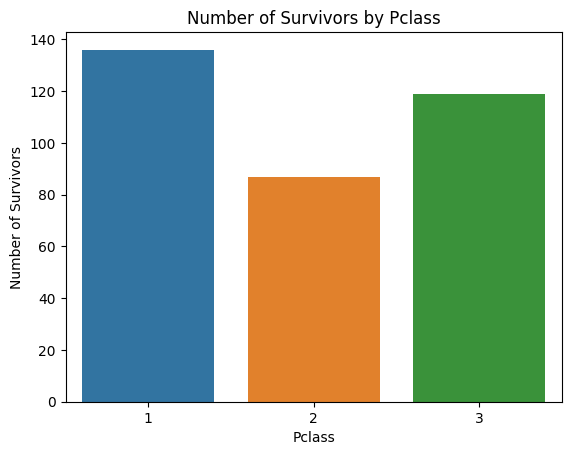

In [7]:
survivedByClass = train_df.groupby("Pclass")["Survived"].sum().reset_index()

sns.barplot(x = "Pclass", y = "Survived", data = survivedByClass)
plt.xlabel('Pclass')
plt.ylabel('Number of Survivors')
plt.title('Number of Survivors by Pclass')
plt.show()

## Data Preprocessing

In [8]:
train_df.drop(columns=["PassengerId", "Name"], inplace=True)

In [9]:
test_df.drop(columns=["Name"], inplace=True)

In [10]:
X = train_df.drop(columns=["Survived"])
y = train_df["Survived"]

In [11]:
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

## Fill missing values

In [12]:
X[numerical_features] = X[numerical_features].fillna(X[numerical_features].median())
X[categorical_features] = X[categorical_features].fillna("None")

In [13]:
test_df[numerical_features] = test_df[numerical_features].fillna(test_df[numerical_features].median())
test_df[categorical_features] = test_df[categorical_features].fillna("None")

## Correlation Matrix Visualization

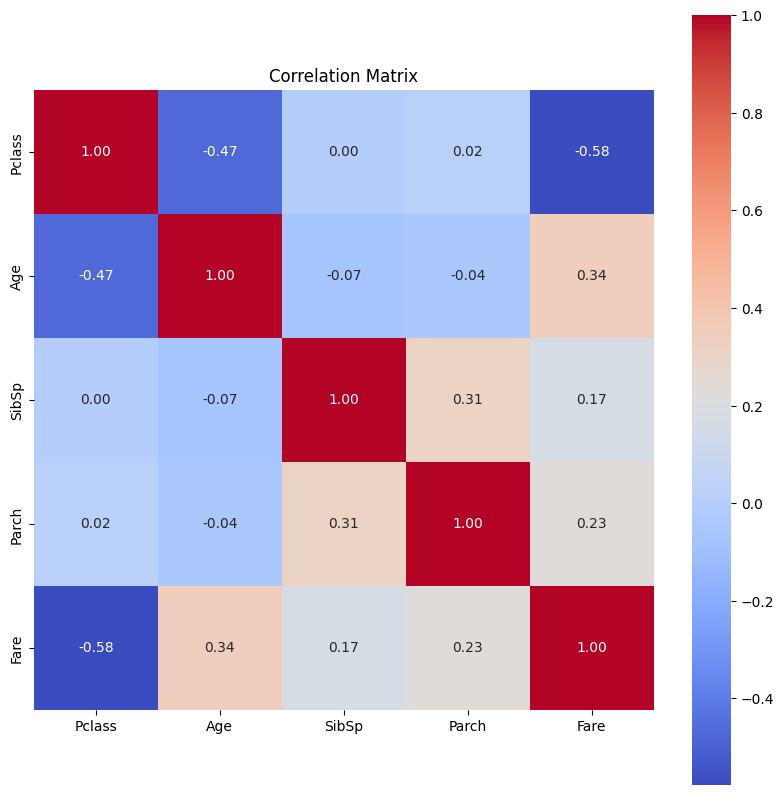

In [14]:
correlation_matrix = test_df[numerical_features].corr()
plt.figure(figsize=(10, 10))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation Matrix')
plt.show()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## CatBoost Model 

In [16]:
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.01,
    depth=4,
    l2_leaf_reg=1,
    cat_features=categorical_features,
    verbose=0
)

catboost_model.fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)
print(f"CatBoost Accuracy: {accuracy_score(y_test, y_pred):.4f}")

CatBoost Accuracy: 0.8101


### Feature Importance Analysis

In [17]:
feature_importances = catboost_model.get_feature_importance()
feature_names = catboost_model.feature_names_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

    Feature  Importance
1       Sex   34.514918
2       Age   14.611875
5    Ticket   12.898859
0    Pclass   10.699514
6      Fare    8.520676
7     Cabin    7.579465
8  Embarked    6.702363
3     SibSp    3.198532
4     Parch    1.273797


## Random Forest Model 

In [18]:
rf_clf = RandomForestClassifier(random_state=42)

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

In [20]:
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", rf_clf)
])

In [21]:
rf_param_distributions = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [10, 20, None],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__bootstrap": [True, False],
}

rf_search = RandomizedSearchCV(
    rf_pipeline, rf_param_distributions, n_iter=10, cv=5,
    scoring="accuracy", random_state=42, n_jobs=-1
)

rf_search.fit(X, y)

print(f"Best Random Forest Params: {rf_search.best_params_}")
print(f"Best RF Accuracy: {rf_search.best_score_}")

Best Random Forest Params: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': None, 'classifier__bootstrap': True}
Best RF Accuracy: 0.8338836231247253


## XGBoost Model 

In [22]:
xgb_clf = XGBClassifier(objective="binary:logistic", random_state=42)

In [23]:
xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", xgb_clf)
])

In [24]:
xgb_param_grid = {
    "classifier__n_estimators": [100, 200, 500],
    "classifier__learning_rate": [0.01, 0.05, 0.1],
    "classifier__max_depth": [3, 5, 7],
    "classifier__subsample": [0.8, 1.0],
    "classifier__colsample_bytree": [0.8, 1.0]
}

xgb_search = RandomizedSearchCV(
    xgb_pipeline, xgb_param_grid, n_iter=10, cv=5,
    scoring="accuracy", random_state=42, verbose=1, n_jobs=-1
)

xgb_search.fit(X, y)

print(f"Best XGBoost Params: {xgb_search.best_params_}")
print(f"Best XGB Accuracy: {xgb_search.best_score_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best XGBoost Params: {'classifier__subsample': 1.0, 'classifier__n_estimators': 500, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.05, 'classifier__colsample_bytree': 1.0}
Best XGB Accuracy: 0.8361559224154165


## Stacking Classifier Setup

In [25]:
base_models = [
    ('xgb', rf_search.best_estimator_),
    ('catboost', catboost_model),
    ('rf', xgb_search.best_estimator_)
]

In [26]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

meta_model = SVC(probability=True, C=0.5, kernel="rbf")

# Train stacking model with cross-validation
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=kf)

## Cross-Validation for Stacking Model and submission

In [27]:
# Perform cross-validation
stacking_cv_scores = cross_val_score(stacking_model, X, y, cv=kf, scoring="accuracy")

# Print cross-validation results
print(f"Stacked Model Cross-Validation Accuracy: {stacking_cv_scores.mean():.4f} ± {stacking_cv_scores.std():.4f}")

# Retrain on the full dataset
stacking_model.fit(X, y)

# Make predictions for submission
X_submission = test_df[X.columns]
y_pred_submission = stacking_model.predict(X_submission)


# Create submission file
submission = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': y_pred_submission})
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")


Stacked Model Cross-Validation Accuracy: 0.8407 ± 0.0229
Submission file saved as 'submission.csv'


In [28]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
